In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# # Uncomment the below to open data source, download sensor data, and store it as a csv locally.

# #Function to get Sensor count history data
# def sensor_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     sensor_data_id = "b2ak-trbp"
#     results = client.get(sensor_data_id, limit=5000000)
#     df = pd.DataFrame.from_records(results)
#     df = df[['date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id', 'sensor_name', 'hourly_counts']]
#     return df

# sensor_history = sensor_count()

# sensor_history.to_csv('sensor_history.csv', index=False)

In [2]:
# read the csv file collected
sensor_history = pd.read_csv('sensor_history.csv')
# choose one single sensor
single_sensor = sensor_history[sensor_history.sensor_id == 4]

In [3]:
sensor_history

,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts
0,2019-11-01T17:00:00.000,2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2019-11-01T17:00:00.000,2019,November,1,Friday,17,39,Alfred Place,604
2,2019-11-01T17:00:00.000,2019,November,1,Friday,17,37,Lygon St (East),216
3,2019-11-01T17:00:00.000,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2019-11-01T17:00:00.000,2019,November,1,Friday,17,36,Queen St (West),774
...,...,...,...,...,...,...,...,...,...
4415569,2022-07-31T19:00:00.000,2022,July,31,Sunday,19,66,State Library - New,1488
4415570,2022-07-31T20:00:00.000,2022,July,31,Sunday,20,66,State Library - New,1212
4415571,2022-07-31T21:00:00.000,2022,July,31,Sunday,21,66,State Library - New,770
4415572,2022-07-31T22:00:00.000,2022,July,31,Sunday,22,66,State Library - New,470


In [6]:
training_set = single_sensor[:80000].iloc[:,8:9].values
test_set = single_sensor[80001:].iloc[:,8:9].values

In [5]:
training_set

array([[2950],
       [2345],
       [2051],
       ...,
       [2266],
       [1858],
       [1843]], dtype=int64)

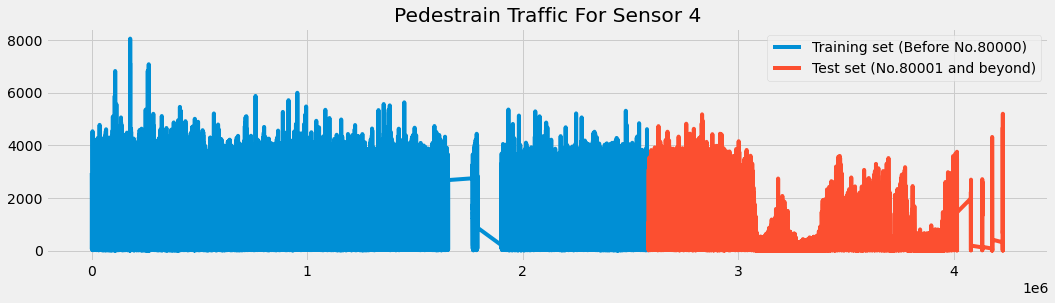

In [4]:
single_sensor["hourly_counts"][:80000].plot(figsize=(16,4),legend=True)
single_sensor["hourly_counts"][80001:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before No.80000)','Test set (No.80001 and beyond)'])
plt.title('Pedestrain Traffic For Sensor 4')
plt.show()

In [7]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [8]:
# Since LSTMs store long term memory state, we create a data structure with 96 timesteps and 1 output
# So for each element of training set, we have 96 previous training set elements 
X_train = []
y_train = []
for i in range(96,len(training_set)):
    X_train.append(training_set_scaled[i-96:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [10]:
# The LSTM architecture
model_lstm = Sequential()
# First LSTM layer with Dropout regularisation
model_lstm.add(LSTM(units=48, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_lstm.add(Dropout(0.2))
# Second LSTM layer
model_lstm.add(LSTM(units=96, return_sequences=True))
model_lstm.add(Dropout(0.2))
# Third LSTM layer
model_lstm.add(LSTM(units=144, return_sequences=True))
model_lstm.add(Dropout(0.2))
# Fourth LSTM layer
model_lstm.add(LSTM(units=192))
model_lstm.add(Dropout(0.2))
# The output layer
model_lstm.add(Dense(units=1))

# Compiling the RNN
adam = Adam(learning_rate = 0.0001)
model_lstm.compile(optimizer=adam,loss='mean_squared_error',metrics = ['accuracy'])
# Fitting to the training set
model_lstm.fit(X_train,y_train,epochs=50,batch_size=64)

Epoch 1/50
1249/1249 [==============================] - 44s 31ms/step - loss: 0.0062 - accuracy: 3.7545e-05
Epoch 2/50
1249/1249 [==============================] - 36s 29ms/step - loss: 0.0032 - accuracy: 5.0060e-05
Epoch 3/50
1249/1249 [==============================] - 37s 29ms/step - loss: 0.0030 - accuracy: 3.7545e-05
Epoch 4/50
1249/1249 [==============================] - 36s 29ms/step - loss: 0.0027 - accuracy: 3.7545e-05
Epoch 5/50
1249/1249 [==============================] - 36s 29ms/step - loss: 0.0025 - accuracy: 3.7545e-05
Epoch 6/50
1249/1249 [==============================] - 36s 29ms/step - loss: 0.0024 - accuracy: 3.7545e-05
Epoch 7/50
1249/1249 [==============================] - 36s 29ms/step - loss: 0.0022 - accuracy: 3.7545e-05
Epoch 8/50
1249/1249 [==============================] - 35s 28ms/step - loss: 0.0021 - accuracy: 3.7545e-05
Epoch 9/50
1249/1249 [==============================] - 36s 28ms/step - loss: 0.0020 - accuracy: 3.7545e-05
Epoch 10/50
1249/1249 [=====

In [11]:
# The GRU architecture
model_gru = Sequential()
# First GRU layer with Dropout regularisation
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_gru.add(Dropout(0.2))
# Second GRU layer
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_gru.add(Dropout(0.2))
# Third GRU layer
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_gru.add(Dropout(0.2))
# Fourth GRU layer
model_gru.add(GRU(units=50, activation='tanh'))
model_gru.add(Dropout(0.2))
# The output layer
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error',metrics = ['accuracy'])
# Fitting to the training set
model_gru.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


d:\dev\anaconda\envs\mop\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


533/533 [==============================] - 15s 20ms/step - loss: 0.0193 - accuracy: 3.7545e-05
Epoch 2/50
533/533 [==============================] - 10s 20ms/step - loss: 0.0056 - accuracy: 3.7545e-05
Epoch 3/50
533/533 [==============================] - 10s 20ms/step - loss: 0.0051 - accuracy: 3.7545e-05
Epoch 4/50
533/533 [==============================] - 10s 20ms/step - loss: 0.0048 - accuracy: 3.7545e-05
Epoch 5/50
533/533 [==============================] - 10s 20ms/step - loss: 0.0046 - accuracy: 3.7545e-05
Epoch 6/50
533/533 [==============================] - 11s 20ms/step - loss: 0.0045 - accuracy: 3.7545e-05
Epoch 7/50
533/533 [==============================] - 10s 20ms/step - loss: 0.0043 - accuracy: 3.7545e-05
Epoch 8/50
533/533 [==============================] - 11s 20ms/step - loss: 0.0042 - accuracy: 3.7545e-05
Epoch 9/50
533/533 [==============================] - 11s 20ms/step - loss: 0.0041 - accuracy: 3.7545e-05
Epoch 10/50
533/533 [==============================] - 10